## Task A

In [ ]:
!pip install spacy

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import MDS
import re
import spacy
import spacy.cli
from spacy.lang.en import stop_words
spacy.cli.download("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 67.9 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# Documents
doc = pd.read_csv('edmunds_extraction.csv')
doc['message'].fillna('', inplace=True)

In [3]:
# Clean Text
nlp = spacy.load('en_core_web_sm')
def clean_text(x): # x is a document
    # conver to lower case 
    x = x.lower()
    # remove new line
    x = re.sub(r'\n', ' ', x)
    # remove link
    x = re.sub(r"https?://[^\s]+", "", x)
    # remove name twitter tag
    x = re.sub(r'@[A-Za-z0-9\_]+', ' ', x) 
    # remove name hashtag tag
    x = re.sub(r'\#[A-Za-z0-9\_]+', ' ', x) 
    # remove specific word - southwest OR airline
    x = re.sub('southwest|airline', ' ', x)
    # lemmatization
    x = ' '.join([token.lemma_ for token in nlp(x)])
    # remove multiple space
    x = re.sub(r' +', ' ', x)
    # remove space before and after the text
    x = x.strip()
    return x

↑ airline? we might need to fix this to our case

In [4]:
# Convert documents into a list
all_documents = doc['message'].tolist()

In [5]:
# List of non-brand words to exclude
exclude_words = ['problem', 'car', 'seat', 'engine', 'wheel', 'door', 'window', 'suv', 'sedan', 'vehicle', 'mpv', 'hatchback', 'crossover', 'convertible', 'coupe', 'truck', 'van', 'roadster', 'cabriolet', 'sportscar']

# Read the list of car brands/models from the CSV file
models = pd.read_csv('models.csv', header=None)


In [6]:
# Clean the model's brand column 
# Define a function to clean the data
def clean_data(value):
    if isinstance(value, str):
        # Remove unwanted characters
        value = value.replace(",", "").replace(".", "")
    return value

# Clean the first and second columns
models[0] = models[0].apply(clean_data)
models[1] = models[1].apply(clean_data)

↑ clean instances like kia, kia. and kia,.

In [7]:
models.shape

(528, 2)

In [8]:
# Create a boolean mask
mask = ~models[0].isin(exclude_words)

# Apply the mask to filter the DataFrame
filtered_models = models[mask]
filtered_models.shape

(524, 2)

↑ removed 4 rows

In [9]:
# lower case
all_documents = [doc.lower() for doc in all_documents]
filtered_models[1] = filtered_models[1].str.lower()
filtered_models[0] = filtered_models[0].str.lower()

In [10]:
filtered_models[1]

0      integra
1       legend
2        vigor
3          rlx
4          ilx
        ...   
523       xc90
524        s60
525        s80
526        v60
527        c70
Name: 1, Length: 524, dtype: object

#### Conver the model name into a list

In [11]:
# Create a mapping dictionary from Model to Brand
model_to_brand = pd.Series(filtered_models[0].values, index=filtered_models[1]).to_dict()

def replace_models_with_brands(text):
    for model, brand in model_to_brand.items():
        text = re.sub(r'\b' + re.escape(model) + r'\b', brand, text)
    return text

# Replace in all_documents
all_documents = [replace_models_with_brands(doc) for doc in all_documents]

In [12]:
# # save as text
# with open('all_documents.txt', 'w') as f:
#     for item in all_documents:
#         f.write("%s\n" % item)

↑ this is to check if the model name is replaced by brand name

In [13]:
# model_names = filtered_models[1].tolist()   

In [14]:
car_brands = filtered_models[0].unique().tolist()

In [15]:
# Define a custom tokenizer function
def unique_tokenizer(text):
    # Apply the clean_text function first (assuming it's already defined)
    text = clean_text(text)
    # Use a set to store unique tokens
    tokens = set(re.findall('[a-zA-Z0-9]{3,}', text))
    return list(tokens)

# # Create an instance of CountVectorizer with the custom tokenizer
# vectorizer = CountVectorizer(vocabulary=car_brands,
#                              max_features=10,
#                              tokenizer=unique_tokenizer,
#                              token_pattern='[a-zA-Z0-9]{3,}')

# # Example data
# test = ['BMW, BMW, FORD, FORD']
# 
# # Transform the data
# dtm = vectorizer.fit_transform(test)

In [16]:
# feature_names = vectorizer.get_feature_names_out()
# 
# # Convert the document-term matrix to a dense array
# dtm_array = dtm.toarray()
# print(feature_names)
# print(dtm_array)

↑ **Here you can see that bmw and ford is counted only once despite they appear twice in the text**

In [32]:
# Initialize the CountVectorizer to transform the text data into a bag-of-words model only for the top 10 most frequent non-stopwords, do the MDS for those words
# Create an instance of CountVectorizer with the custom tokenizer

vectorizer = CountVectorizer(vocabulary=car_brands,
                             max_features=10,
                             tokenizer=unique_tokenizer,
                             token_pattern='[a-zA-Z0-9]{3,}')

# Transform the documents into a document-term matrix
dtm = vectorizer.fit_transform(all_documents)


In [55]:

# Extract feature names (non-stopwords)
feature_names = vectorizer.get_feature_names_out()

# Convert the document-term matrix to a dense array
dtm_array = dtm.toarray()

# Calculate lift between terms
term_lift = np.dot(dtm_array.T, dtm_array)
term_occurrence = np.sum(dtm_array, axis=0)


In [56]:
# Assuming feature_names and term_occurrence are already defined as per your notebook
# Extract the indices of the top 10 most frequent features
top_10_indices = np.argsort(term_occurrence)[-10:]

# Fetch the top 10 feature names and their frequencies
top_10_feature_names = [feature_names[i] for i in top_10_indices]
top_10_frequencies = [term_occurrence[i] for i in top_10_indices]

# Display the top 10 feature names and their frequencies
print("Top 10 Brands and Their Frequencies:")
for name, freq in zip(reversed(top_10_feature_names), reversed(top_10_frequencies)):
    print(f"{name}: {freq}")


Top 10 Brands and Their Frequencies:
honda: 2155
ford: 1410
toyota: 1033
hyundai: 633
mazda: 606
nissan: 594
saturn: 260
chevrolet: 259
chrysler: 240
subaru: 165


In [57]:
# Recheck for brands with zero occurrences and handle them
zero_occurrence_indices = np.where(term_occurrence == 0)[0]
if len(zero_occurrence_indices) > 0:
    for idx in zero_occurrence_indices:
        print(f"Brand '{feature_names[idx]}' is not mentioned and will be excluded from MDS analysis.")
    # Exclude brands with zero occurrences
    valid_indices = np.setdiff1d(np.arange(len(feature_names)), zero_occurrence_indices)
    dtm_array = dtm_array[:, valid_indices]
    term_lift = term_lift[valid_indices][:, valid_indices]
    term_occurrence = term_occurrence[valid_indices]
    feature_names = [feature_names[i] for i in valid_indices]

# Select indices of top 10 most frequent brands
top_10_indices = np.argsort(term_occurrence)[-10:]

# Filter DTM and feature names for top 10 brands
dtm_array = dtm.toarray()[:, top_10_indices]
feature_names = [feature_names[i] for i in top_10_indices]
    
# Add a small constant to avoid division by zero and calculate lift matrix
constant = 1e-8
lift_matrix = np.zeros((len(feature_names), len(feature_names)))
for i in range(len(feature_names)):
    for j in range(len(feature_names)):
        if term_occurrence[i] * term_occurrence[j] > 0:
            lift_matrix[i, j] = term_lift[i, j] / (term_occurrence[i] * term_occurrence[j] + constant)
        else:
            lift_matrix[i, j] = 0  # Set lift to 0 if either term does not occur

# Calculate dissimilarity matrix based on lift
dissimilarity_matrix = np.where(lift_matrix != 0, 1 / lift_matrix, 0)
print(dissimilarity_matrix)

Brand 'hyndai kia' is not mentioned and will be excluded from MDS analysis.
Brand 'toyata' is not mentioned and will be excluded from MDS analysis.
Brand 'volkwagen' is not mentioned and will be excluded from MDS analysis.
[[   75.          1650.           937.5         1425.
      0.          4856.25        9000.00000001     0.
   5565.78947368  2693.75      ]
 [ 1650.            44.           687.5         1254.
    469.33333334  5698.00000001     0.          3520.00000001
   6893.33333333  4990.52631579]
 [  937.5          687.5          125.          1781.25
   1000.          3597.22222222  4285.71428572 10000.00000001
   7050.          4415.98360656]
 [ 1425.          1254.          1781.25          57.
    260.57142857   738.15        2280.          1140.
   4018.5         4724.42307692]
 [    0.           469.33333334  1000.           260.57142857
     32.           828.8         3840.             0.
   9024.          7662.22222222]
 [ 4856.25        5698.00000001  3597.22222222

In [59]:
lift_df = pd.DataFrame(lift_matrix, index=feature_names, columns=feature_names)
lift_df

,subaru,chrysler,chevrolet,saturn,nissan,mazda,hyundai,toyota,ford,honda
subaru,0.013333,0.000606,0.001067,0.000702,0.000000,0.000206,0.000111,0.000000,0.000180,0.000371
chrysler,0.000606,0.022727,0.001455,0.000797,0.002131,0.000176,0.000000,0.000284,0.000145,0.000200
chevrolet,0.001067,0.001455,0.008000,0.000561,0.001000,0.000278,0.000233,0.000100,0.000142,0.000226
saturn,0.000702,0.000797,0.000561,0.017544,0.003838,0.001355,0.000439,0.000877,0.000249,0.000212
nissan,0.000000,0.002131,0.001000,0.003838,0.031250,0.001207,0.000260,0.000000,0.000111,0.000131
mazda,0.000206,0.000176,0.000278,0.001355,0.001207,0.003861,0.000434,0.000579,0.000268,0.000265
hyundai,0.000111,0.000000,0.000233,0.000439,0.000260,0.000434,0.004167,0.001406,0.000278,0.000263
toyota,0.000000,0.000284,0.000100,0.000877,0.000000,0.000579,0.001406,0.012500,0.000239,0.000209
ford,0.000180,0.000145,0.000142,0.000249,0.000111,0.000268,0.000278,0.000239,0.000709,0.000237
honda,0.000371,0.000200,0.000226,0.000212,0.000131,0.000265,0.000263,0.000209,0.000237,0.000464


In [51]:
print("Top 10 brands by frecuency: ", feature_names)

Top 10 brands by frecuency:  ['subaru', 'chrysler', 'chevrolet', 'saturn', 'nissan', 'mazda', 'hyundai', 'toyota', 'ford', 'honda']


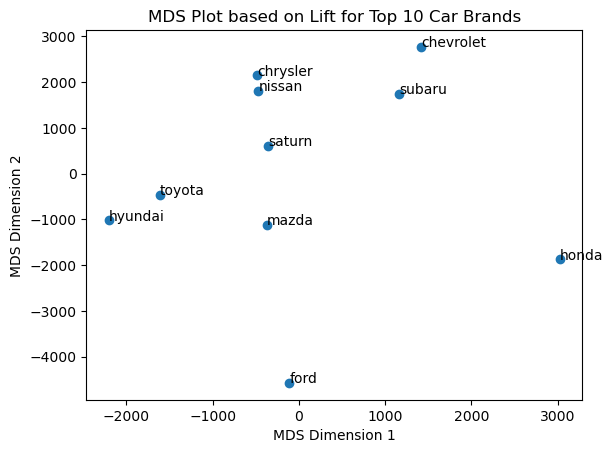

In [53]:
# Apply MDS to reduce dimensionality to 2D
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_result = mds.fit_transform(dissimilarity_matrix)

# Plot the MDS result
plt.scatter(mds_result[:, 0], mds_result[:, 1])

# Annotate points with feature names
for i, txt in enumerate(feature_names):
    plt.annotate(txt, (mds_result[i, 0], mds_result[i, 1]))

plt.title('MDS Plot based on Lift for Top 10 Car Brands')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.show()

## Task B

### Honda:
Positioning: Honda is positioned at the far right of the MDS Dimension 1, which suggests a significant differentiation from most other car brands in the dataset. This could indicate a unique selling proposition (USP) that Honda possesses, setting it apart in the discussions or perceptions among consumers.

Brand Strengths: Honda's outlier position could be reflective of strong brand associations with specific attributes, such as reliability, engineering, or value for money. The fact that it is far removed from the cluster of other brands may suggest that it owns a particular niche or that its brand is not commonly confused with others.

Consumer Perception and Strategy: Given Honda's distinctive placement, the company could leverage this in their marketing strategy by emphasizing the qualities that lead to this separation. If the attributes are positive, Honda should reinforce these in communication. If there are negative connotations, Honda might need to address these in order to move closer to the cluster, if that is desirable.

### Subaru:
Positioning: Subaru is positioned towards the upper right quadrant, but closer to the center of the plot compared to Honda. This indicates that Subaru shares some commonalities with other brands, especially Chevrolet, but still retains a level of distinctiveness in some aspects.

Niche Market Appeal: Subaru’s position may reflect its reputation for producing vehicles that are robust, suitable for off-road and all-weather conditions, appealing to a niche market that values these characteristics. Their position suggests that they are recognized for this niche, but not as strongly separated as Honda, indicating potential overlap with other brands in certain aspects.

Marketing Implications: Subaru could focus on strengthening its unique brand elements that appeal to its niche market. At the same time, it could explore what attributes shared with brands like Chevrolet contribute to its positioning and decide whether to emphasize or differentiate from these in future strategies.

**For both Honda and Subaru, the insights suggest different strategic approaches. Honda may benefit from capitalizing on and reinforcing its distinct brand positioning, while Subaru could explore the dual strategy of niche market reinforcement and investigation into shared attributes with other brands for potential opportunities. It is critical for both brands to delve into the qualitative aspects behind their positioning to fully understand the drivers of their brand perception and strategize accordingly.**